# Trans-pQTL Colocalization

**Created**: 26 March 2022

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(data.table)
library(coloc)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("01_Colocalization/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


This is coloc version 5.1.1



## Load Summary Information

Load cis- and trans-pQTL summaries

In [3]:
cis.pqtl.summary <- readRDS("/nfs/users/nfs_n/nm18/gains_team282/proteomics/pqtl/pqtl_ms2019/cis_pqtl_all.RDS") %>%
    as.data.frame() %>%
    dplyr::mutate(pQTL_ID=pQTL_Protein)

In [4]:
cis.pqtl.loci <- split(cis.pqtl.summary, cis.pqtl.summary$pQTL_ID)

In [5]:
trans.pqtl.summary <- readRDS("/nfs/users/nfs_n/nm18/gains_team282/proteomics/pqtl/pqtl_ms2019/trans_pqtl_all.RDS") %>%
    as.data.frame() %>%
    dplyr::mutate(pQTL_ID=paste0(pQTL_Protein, "-", pQTL_Locus))

Split summary statistics by locus.

In [6]:
trans.pqtl.loci <- split(trans.pqtl.summary, trans.pqtl.summary$pQTL_ID)

## Load Gene and Protein Expression

Load gene and protein expression, which is required to estimate the standard deviation of the traits for COLOC.

In [7]:
gene.exp <- read.table("/lustre/scratch119/humgen/projects/gains_team282/eqtl/data/logcpm_864_20412_hla.txt")
gene.exp <- t(gene.exp)
rownames(gene.exp) <- gsub("^GA", "", rownames(gene.exp))

In [8]:
pqtl.geno <- fread("/nfs/users/nfs_n/nm18/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.fam", drop=3:6)
colnames(pqtl.geno) <- c("family", "individual")
protein.exp <- read.csv("/lustre/scratch119/humgen/projects/gains_team282/proteomics/MS2019_processed_data/data_291x1860_MS2019.csv", row.names=1)
protein.exp <- t(protein.exp)
rownames(protein.exp) <- gsub("^X", "", gsub("\\..*$", "", rownames(protein.exp)))
protein.info <- read.csv("/lustre/scratch119/humgen/projects/gains_team282/proteomics/MS2019_processed_data/sample_info_1860_MS2019.csv", row.names=1)
protein.info <- protein.info %>%
    dplyr::filter(Patient %in% pqtl.geno$individual)
protein.info$Patient <- gsub("^GA", "", protein.info$Patient)
protein.exp <- protein.exp[paste0(protein.info$Injection),]

## COLOC trans-pQTL

Identify all the trans-pQTL that were discovered.

In [9]:
trans.pqtl.geno <- fread("~/gains_team282/nikhil/data/genotypes/trans_pqtl_genotypes.raw", drop=2:6, sep=" ") %>%
    as.data.frame()

rownames(trans.pqtl.geno) <- trans.pqtl.geno$FID
trans.pqtl.geno$FID <- NULL
colnames(trans.pqtl.geno) <- gsub("_.*$", "", colnames(trans.pqtl.geno))
trans.pqtl.geno <- as.matrix(trans.pqtl.geno)

In [10]:
trans.pqtl.summary %>%
    dplyr::group_by(pQTL_ID) %>%
    dplyr::summarize(Chr=Chr[1])

pQTL_ID,Chr
<chr>,<int>
P00751-pQTL_1,14
P02787-pQTL_1,14
P10909-pQTL_1,16
P19827-pQTL_1,16
P35858-pQTL_1,8
Q92954-pQTL_1,14


### Chromosome 8

Chromosome 8 trans-pQTL for insulin-like growth factor-binding protein complex acid labile subunit (IGFALS). Cannot be tested for colocalisation with any other trans-pQTL, but create the data structure for later analysis.

In [11]:
chr.8.ids <- c("P35858-pQTL_1")

chr.8.loci <- lapply(chr.8.ids, function(id) {

    locus <- list()
    locus$beta <- trans.pqtl.loci[[id]]$pQTL_beta
    locus$varbeta <- trans.pqtl.loci[[id]]$pQTL_SE^2
    locus$snp <- trans.pqtl.loci[[id]]$SNP
    locus$position <- trans.pqtl.loci[[id]]$Position
    locus$type <- "quant"
    locus$sdY <- sd(protein.exp[,trans.pqtl.loci[[id]]$pQTL_Protein[1]], na.rm=TRUE)
    
    return(locus)
})

names(chr.8.loci) <- chr.8.ids

### Chromosome 14

Chromosome 14 trans-pQTL for complement factor B (CFB), serotransferrin (TF), and proteoglycan 4 (PRG4).

In [12]:
chr.14.ids <- c("P00751-pQTL_1", "P02787-pQTL_1", "Q92954-pQTL_1")

chr.14.loci <- lapply(chr.14.ids, function(id) {

    locus <- list()
    locus$beta <- trans.pqtl.loci[[id]]$pQTL_beta
    locus$varbeta <- trans.pqtl.loci[[id]]$pQTL_SE^2
    locus$snp <- trans.pqtl.loci[[id]]$SNP
    locus$position <- trans.pqtl.loci[[id]]$Position
    locus$type <- "quant"
    locus$sdY <- sd(protein.exp[,trans.pqtl.loci[[id]]$pQTL_Protein[1]], na.rm=TRUE)
    
    return(locus)
})

names(chr.14.loci) <- chr.14.ids

CFB and TF colocalise. CFB does not colocalise with PRG4. TF also does not colocalise with PRG4. Thus, the signal underlying CFB and TF is separate from the one underlying PRG4.

In [13]:
chr.14.abf.res <- list()

In [14]:
abf.res = suppressMessages(coloc.abf(chr.14.loci[[1]], chr.14.loci[[2]]))

abf.res.df.1 = data.frame(t(abf.res$summary))
abf.res.df.1$trans.pQTL.1 = chr.14.ids[1]
abf.res.df.1$trans.pQTL.2 = chr.14.ids[2]

chr.14.abf.res[[1]] <- abf.res$result
chr.14.abf.res[[1]]$pQTL_1 = names(chr.14.loci)[1]
chr.14.abf.res[[1]]$pQTL_2 = names(chr.14.loci)[2]

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 7.05e-99  2.24e-28  9.41e-74  1.99e-03  9.98e-01 
[1] "PP abf for shared variant: 99.8%"


In [15]:
abf.res = suppressMessages(coloc.abf(chr.14.loci[[2]], chr.14.loci[[3]]))

abf.res.df.2 = data.frame(t(abf.res$summary))
abf.res.df.2$trans.pQTL.1 = chr.14.ids[2]
abf.res.df.2$trans.pQTL.2 = chr.14.ids[3]

chr.14.abf.res[[2]] <- abf.res$result
chr.14.abf.res[[2]]$pQTL_1 = names(chr.14.loci)[2]
chr.14.abf.res[[2]]$pQTL_2 = names(chr.14.loci)[3]

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 2.12e-29  2.83e-04  7.48e-26  1.00e+00  2.04e-04 
[1] "PP abf for shared variant: 0.0204%"


In [16]:
abf.res = suppressMessages(coloc.abf(chr.14.loci[[1]], chr.14.loci[[3]]))

abf.res.df.3 = data.frame(t(abf.res$summary))
abf.res.df.3$trans.pQTL.1 = chr.14.ids[1]
abf.res.df.3$trans.pQTL.2 = chr.14.ids[3]

chr.14.abf.res[[3]] <- abf.res$result
chr.14.abf.res[[3]]$pQTL_1 = names(chr.14.loci)[1]
chr.14.abf.res[[3]]$pQTL_2 = names(chr.14.loci)[3]

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 8.91e-75  2.83e-04  3.15e-71  1.00e+00  1.56e-04 
[1] "PP abf for shared variant: 0.0156%"


In [17]:
chr.14.res <- rbind(abf.res.df.1, abf.res.df.2, abf.res.df.3)
chr.14.res$Locus = "14"

### Chromosome 16

Chromosome 16 trans-pQTL for clusterin (CLU) and inter-alpha-trypsin inhibitor heavy chain H1 precursor (ITIH1).

In [18]:
chr.16.ids <- c("P10909-pQTL_1", "P19827-pQTL_1")

chr.16.loci <- lapply(chr.16.ids, function(id) {

    locus <- list()
    locus$beta <- trans.pqtl.loci[[id]]$pQTL_beta
    locus$varbeta <- trans.pqtl.loci[[id]]$pQTL_SE^2
    locus$snp <- trans.pqtl.loci[[id]]$SNP
    locus$position <- trans.pqtl.loci[[id]]$Position
    locus$type <- "quant"
    locus$sdY <- sd(protein.exp[,trans.pqtl.loci[[id]]$pQTL_Protein[1]], na.rm=TRUE)
    
    return(locus)
})

names(chr.16.loci) <- chr.16.ids

CLU colocalises with ITIH1.

In [19]:
chr.16.abf.res <- list()

In [20]:
abf.res = suppressMessages(coloc.abf(chr.16.loci[[1]], chr.16.loci[[2]]))

chr.16.abf.res[[1]] <- abf.res$result
chr.16.abf.res[[1]]$pQTL_1 = names(chr.16.loci)[1]
chr.16.abf.res[[1]]$pQTL_2 = names(chr.16.loci)[2]

chr.16.res = data.frame(t(abf.res$summary))
chr.16.res$trans.pQTL.1 = chr.16.ids[1]
chr.16.res$trans.pQTL.2 = chr.16.ids[2]
chr.16.res$Locus = "16"

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 1.82e-24  2.24e-16  1.19e-11  4.66e-04  1.00e+00 
[1] "PP abf for shared variant: 100%"


### Results summary

In [21]:
coloc.res = dplyr::bind_rows(chr.14.res, chr.16.res) %>%
    dplyr::mutate(PP3andPP4 = PP.H3.abf + PP.H4.abf) %>%
    dplyr::mutate(Coloc.Factor = PP.H4.abf / PP3andPP4) %>%
    dplyr::mutate(Colocalise = (PP3andPP4 > 0.25) & (Coloc.Factor > 0.7))

In [22]:
head(coloc.res)

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,trans.pQTL.1,trans.pQTL.2,Locus,PP3andPP4,Coloc.Factor,Colocalise
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>
1,3148,7.048377e-99,2.239966e-28,9.413375e-74,0.0019935532,0.9980064468,P00751-pQTL_1,P02787-pQTL_1,14,1.0000000,0.9980064468,TRUE
2,3102,2.119676e-29,2.830908e-04,7.483977e-26,0.9995134055,0.0002035037,P02787-pQTL_1,Q92954-pQTL_1,14,0.9997169,0.0002035613,FALSE
3,3102,8.908282e-75,2.831041e-04,3.145263e-71,0.9995607139,0.0001561820,P00751-pQTL_1,Q92954-pQTL_1,14,0.9997169,0.0001562262,FALSE
4,2870,1.824893e-24,2.240618e-16,1.193580e-11,0.0004659529,0.9995340471,P10909-pQTL_1,P19827-pQTL_1,16,1.0000000,0.9995340471,TRUE


## COLOC with cis-pQTL

### Chromosome 8

Check if any *cis*-pQTL are in the region of the *trans*-pQTL. There are none.

In [23]:
chr.8.range <- range(unlist(lapply(chr.8.loci, function(x) { x$position })))

cis.pqtl.summary %>%
    dplyr::filter(Chr == 8) %>%
    dplyr::filter(Position >= chr.8.range[1], Position <= chr.8.range[2]) %>%
    dplyr::count(Gene)

Gene,n
<chr>,<int>


### Chromosome 14

Check if any *cis*-pQTL are in the region of the *trans*-pQTL. There are 6 *cis*-pQTL that overlap the window of the *trans*-pQTL. None of them colocalise. Suggestive associations with PRG4 with plasma serine protease inhibitor (SERPINA5) and alpha-1-antichymotrypsin (SERPINA3).

In [24]:
chr.14.range <- range(unlist(lapply(chr.14.loci, function(x) { x$position })))

chr.14.cis.proteins <- cis.pqtl.summary %>%
    dplyr::filter(Chr == 14) %>%
    dplyr::filter(Position >= chr.14.range[1], Position <= chr.14.range[2]) %>%
    dplyr::count(pQTL_Protein)

dim(chr.14.cis.proteins)[1]

[1] 6

In [25]:
lapply(chr.14.cis.proteins$pQTL_Protein, function(protein.id) {

    cis.pqtl = list()
    cis.pqtl$beta = cis.pqtl.loci[[protein.id]]$pQTL_beta
    cis.pqtl$varbeta = cis.pqtl.loci[[protein.id]]$pQTL_SE^2
    cis.pqtl$snp = cis.pqtl.loci[[protein.id]]$SNP
    cis.pqtl$position = cis.pqtl.loci[[protein.id]]$Position
    cis.pqtl$type = "quant"
    cis.pqtl$sdY = sd(protein.exp[, protein.id], na.rm=TRUE)

    lapply(names(chr.14.loci), function(chr.14.id) {
        log = capture.output({
            abf.res = suppressWarnings(coloc.abf(chr.14.loci[[chr.14.id]], cis.pqtl))
        })
        abf.res = data.frame(t(abf.res$summary))
        abf.res$Cis_pQTL_Protein = protein.id
        abf.res$Trans_pQTL = chr.14.id
        return(abf.res)
    }) %>%
        do.call(rbind, .)
}) %>%
    do.call(rbind, .) %>%
    dplyr::mutate(PP3andPP4 = PP.H3.abf + PP.H4.abf) %>%
    dplyr::mutate(Coloc.Factor = PP.H4.abf / (PP3andPP4)) %>%
    dplyr::mutate(Colocalise = (PP3andPP4 > 0.25) & (Coloc.Factor > 0.7)) %>%
    dplyr::arrange(desc(Coloc.Factor)) %>%
    head()

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,Cis_pQTL_Protein,Trans_pQTL,PP3andPP4,Coloc.Factor,Colocalise
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<lgl>
1,2726,1.969746e-04,0.6954590,5.455089e-05,0.1924913,0.11179820,P01011,Q92954-pQTL_1,0.3042895,0.36740739,FALSE
2,2778,2.159898e-04,0.7625968,5.427829e-05,0.1915952,0.04553776,P05154,Q92954-pQTL_1,0.2371330,0.19203472,FALSE
3,2783,5.879561e-26,0.7852378,1.478165e-26,0.1973972,0.01736509,P05154,P02787-pQTL_1,0.2147622,0.08085726,FALSE
4,2783,2.470984e-71,0.7852758,6.212235e-72,0.1974068,0.01731741,P05154,P00751-pQTL_1,0.2147242,0.08064955,FALSE
5,2731,5.761013e-26,0.7694053,1.599626e-26,0.2136191,0.01697559,P01011,P02787-pQTL_1,0.2305947,0.07361656,FALSE
6,2731,2.422093e-71,0.7697383,6.725280e-72,0.2137120,0.01654965,P01011,P00751-pQTL_1,0.2302617,0.07187323,FALSE


### Chromosome 16

Check if any *cis*-pQTL are in the region of the *trans*-pQTL. There are 2 *cis*-pQTL that overlap the window of the *trans*-pQTL. None of them colocalise, although the associations with haptoglobin (HPT) are pretty suggestive (close to 0.7 Coloc factor).

In [26]:
chr.16.range <- range(unlist(lapply(chr.16.loci, function(x) { x$position })))

chr.16.cis.proteins <- cis.pqtl.summary %>%
    dplyr::filter(Chr == 16) %>%
    dplyr::filter(Position >= chr.16.range[1], Position <= chr.16.range[2]) %>%
    dplyr::count(pQTL_Protein)

dim(chr.16.cis.proteins)[1]

[1] 2

In [27]:
lapply(chr.16.cis.proteins$pQTL_Protein, function(protein.id) {

    cis.pqtl = list()
    cis.pqtl$beta = cis.pqtl.loci[[protein.id]]$pQTL_beta
    cis.pqtl$varbeta = cis.pqtl.loci[[protein.id]]$pQTL_SE^2
    cis.pqtl$snp = cis.pqtl.loci[[protein.id]]$SNP
    cis.pqtl$position = cis.pqtl.loci[[protein.id]]$Position
    cis.pqtl$type = "quant"
    cis.pqtl$sdY = sd(protein.exp[, protein.id], na.rm=TRUE)

    lapply(names(chr.16.loci), function(chr.16.id) {
        log = capture.output({
            abf.res = suppressWarnings(coloc.abf(chr.16.loci[[chr.16.id]], cis.pqtl))
        })
        abf.res = data.frame(t(abf.res$summary))
        abf.res$Cis_pQTL_Protein = protein.id
        abf.res$Trans_pQTL = chr.16.id
        return(abf.res)
    }) %>%
        do.call(rbind, .)
}) %>%
    do.call(rbind, .) %>%
    dplyr::mutate(PP3andPP4 = PP.H3.abf + PP.H4.abf) %>%
    dplyr::mutate(Coloc.Factor = PP.H4.abf / (PP3andPP4)) %>%
    dplyr::mutate(Colocalise = (PP3andPP4 > 0.25) & (Coloc.Factor > 0.7))

nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,Cis_pQTL_Protein,Trans_pQTL,PP3andPP4,Coloc.Factor,Colocalise
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<lgl>
2741,1.464657e-09,1.798317e-01,2.248713e-09,0.2755541,0.5446142,P00738,P10909-pQTL_1,0.8201683,0.6640273,FALSE
2741,2.649886e-14,1.733171e-01,4.068416e-14,0.2655355,0.5611474,P00738,P19827-pQTL_1,0.8266829,0.6787940,FALSE
2741,8.886334e-13,1.091071e-04,3.403973e-09,0.4173599,0.5825310,P00739,P10909-pQTL_1,0.9998909,0.5825946,FALSE
2741,1.489156e-17,9.739894e-05,5.704315e-14,0.3724660,0.6274366,P00739,P19827-pQTL_1,0.9999026,0.6274977,FALSE


## COLOC with cis-eQTL

### Chromosome 8

Check if any *cis*-eQTL are in the region of the *trans*-pQTL. There are 16 instances. None of them colocalise. Colocalisation with Syndecan 2 (*SDC2*) is suggestive.

In [28]:
chr.8.range <- range(unlist(lapply(chr.8.loci, function(x) { x$position })))

chr.8.cis.genes <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/colocalization/cis_eqtl/conditional_effects/LMM/chr8_conditional_cis_eQTL_summary_statistics.tsv") %>%
    as.data.frame() %>%
    dplyr::filter(Position >= chr.8.range[1], Position <= chr.8.range[2]) %>%
    dplyr::count(Gene)

dim(chr.8.cis.genes)[1]

[1] 16

In [29]:
chr.8.gene.sum <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/colocalization/cis_eqtl/conditional_effects/LMM/chr8_conditional_cis_eQTL_summary_statistics.tsv") %>%
    as.data.frame() %>%
    dplyr::filter(Gene %in% chr.8.cis.genes$Gene)

In [30]:
lapply(chr.8.cis.genes$Gene, function(gene.id) {
    
    gene.sum = subset(chr.8.gene.sum, Gene == gene.id)
    gene.signals = split(gene.sum, gene.sum$Signal)
    
    lapply(names(gene.signals), function(eqtl.signal) {
      
        cis.eqtl = list()
        cis.eqtl$beta = gene.signals[[eqtl.signal]]$Beta
        cis.eqtl$varbeta = gene.signals[[eqtl.signal]]$SE^2
        cis.eqtl$snp = gene.signals[[eqtl.signal]]$SNP
        cis.eqtl$position = gene.signals[[eqtl.signal]]$Position
        cis.eqtl$type = "quant"
        cis.eqtl$sdY = sd(gene.exp[, gene.id], na.rm=TRUE)
        
        lapply(names(chr.8.loci), function(chr.8.id) {
            log = capture.output({
                abf.res = suppressWarnings(coloc.abf(chr.8.loci[[chr.8.id]], cis.eqtl))
            })
            abf.res = data.frame(t(abf.res$summary))
            abf.res$Cis_eQTL_Gene = gene.id
            abf.res$Cis_eQTL_Signal = eqtl.signal
            abf.res$Trans_pQTL = chr.8.id
            return(abf.res)
        }) %>%
            do.call(rbind, .)
    }) %>%
        do.call(rbind, .)
}) %>%
    do.call(rbind, .) %>%
    dplyr::mutate(PP3andPP4 = PP.H3.abf + PP.H4.abf) %>%
    dplyr::mutate(Coloc.Factor = PP.H4.abf / (PP3andPP4)) %>%
    dplyr::mutate(Colocalise = (PP3andPP4 > 0.25) & (Coloc.Factor > 0.7)) %>%
    dplyr::arrange(desc(Coloc.Factor)) %>%
    head()

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,Cis_eQTL_Gene,Cis_eQTL_Signal,Trans_pQTL,PP3andPP4,Coloc.Factor,Colocalise
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>
1,294,9.638137e-01,1.543771e-02,1.947194e-02,0.0003109225,0.0009656875,ENSG00000180543,1,P35858-pQTL_1,0.001276610,0.7564467,FALSE
2,1274,2.145889e-05,7.749053e-01,2.837281e-06,0.1023347344,0.1227357063,ENSG00000169439,1,P35858-pQTL_1,0.225070441,0.5453213,FALSE
3,1021,8.788160e-01,6.652392e-02,4.779698e-02,0.0036148499,0.0032482443,ENSG00000164951,1,P35858-pQTL_1,0.006863094,0.4732915,FALSE
4,894,8.696816e-01,5.815956e-02,6.454116e-02,0.0043128556,0.0033048631,ENSG00000104324,1,P35858-pQTL_1,0.007617719,0.4338390,FALSE
5,894,8.474362e-01,5.667191e-02,8.580286e-02,0.0057336716,0.0043553238,ENSG00000104324,2,P35858-pQTL_1,0.010088995,0.4316905,FALSE
6,1881,3.309686e-13,7.137628e-14,8.066343e-01,0.1739383621,0.0194273172,ENSG00000265817,1,P35858-pQTL_1,0.193365679,0.1004693,FALSE


### Chromosome 14

Check if any *cis*-eQTL are in the region of the *trans*-pQTL. There are 19 instances. None of them colocalise. Most suggestive ones are calmin (*CLMN*) and protein phosphatase 4 regulatory subunit 4 (*PPP4R4*)

In [31]:
chr.14.range <- c(
    max(sapply(chr.14.loci, function(x) { min(x$position) })),
    min(sapply(chr.14.loci, function(x) { max(x$position) }))
)

chr.14.cis.genes <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/colocalization/cis_eqtl/conditional_effects/LMM/chr14_conditional_cis_eQTL_summary_statistics.tsv") %>%
    as.data.frame() %>%
    dplyr::filter(Position >= chr.14.range[1], Position <= chr.14.range[2]) %>%
    dplyr::count(Gene)

dim(chr.14.cis.genes)[1]

[1] 19

In [32]:
chr.14.gene.sum <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/colocalization/cis_eqtl/conditional_effects/LMM/chr14_conditional_cis_eQTL_summary_statistics.tsv") %>%
    as.data.frame() %>%
    dplyr::filter(Gene %in% chr.14.cis.genes$Gene)

In [33]:
lapply(chr.14.cis.genes$Gene, function(gene.id) {
    
    gene.sum = subset(chr.14.gene.sum, Gene == gene.id)
    gene.signals = split(gene.sum, gene.sum$Signal)
    
    lapply(names(gene.signals), function(eqtl.signal) {
      
        cis.eqtl = list()
        cis.eqtl$beta = gene.signals[[eqtl.signal]]$Beta
        cis.eqtl$varbeta = gene.signals[[eqtl.signal]]$SE^2
        cis.eqtl$snp = gene.signals[[eqtl.signal]]$SNP
        cis.eqtl$position = gene.signals[[eqtl.signal]]$Position
        cis.eqtl$type = "quant"
        cis.eqtl$sdY = sd(gene.exp[, gene.id], na.rm=TRUE)
        
        lapply(names(chr.14.loci), function(chr.14.id) {
            log = capture.output({
                abf.res = suppressWarnings(coloc.abf(chr.14.loci[[chr.14.id]], cis.eqtl))
            })
            abf.res = data.frame(t(abf.res$summary))
            abf.res$Cis_eQTL_Gene = gene.id
            abf.res$Cis_eQTL_Signal = eqtl.signal
            abf.res$Trans_pQTL = chr.14.id
            return(abf.res)
        }) %>%
            do.call(rbind, .)
    }) %>%
        do.call(rbind, .)
}) %>%
    do.call(rbind, .) %>%
    dplyr::mutate(PP3andPP4 = PP.H3.abf + PP.H4.abf) %>%
    dplyr::mutate(Coloc.Factor = PP.H4.abf / (PP3andPP4)) %>%
    dplyr::mutate(Colocalise = (PP3andPP4 > 0.25) & (Coloc.Factor > 0.7)) %>%
    dplyr::filter(PP3andPP4 > 0.25) %>%
    dplyr::arrange(desc(Coloc.Factor)) %>%
    head()

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,Cis_eQTL_Gene,Cis_eQTL_Signal,Trans_pQTL,PP3andPP4,Coloc.Factor,Colocalise
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>
1,1669,2.026890e-04,0.7155923,5.638809e-05,0.1989927,0.08515596,ENSG00000165959,1,Q92954-pQTL_1,0.2841486,0.29968810,FALSE
2,2804,2.116972e-04,0.7474379,5.095735e-05,0.1798423,0.07245714,ENSG00000119698,2,Q92954-pQTL_1,0.2522994,0.28718709,FALSE
3,2804,2.118345e-04,0.7479225,5.132958e-05,0.1811583,0.07065597,ENSG00000119698,3,Q92954-pQTL_1,0.2518143,0.28058757,FALSE
4,2794,1.052260e-04,0.3715206,1.698702e-04,0.5997308,0.02847352,ENSG00000119632,2,Q92954-pQTL_1,0.6282043,0.04532525,FALSE
5,2792,6.143964e-05,0.2169245,2.122311e-04,0.7492893,0.03351259,ENSG00000119632,1,Q92954-pQTL_1,0.7828019,0.04281107,FALSE
6,2780,9.181616e-05,0.3241747,1.861719e-04,0.6572977,0.01824966,ENSG00000089737,1,Q92954-pQTL_1,0.6755474,0.02701463,FALSE


### Chromosome 16

Check if any *cis*-eQTL are in the region of the *trans*-pQTL. There are 11 *cis*-eQTL that overlap the window of the *trans*-pQTL. *Cis*-eQTL for exocyst complex component 6 (EXOC6) colocalise with CLU but not with ITIH1.

In [34]:
chr.16.range <- c(
    max(sapply(chr.16.loci, function(x) { min(x$position) })),
    min(sapply(chr.16.loci, function(x) { max(x$position) }))
)

chr.16.cis.genes <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/colocalization/cis_eqtl/conditional_effects/LMM/chr16_conditional_cis_eQTL_summary_statistics.tsv") %>%
    as.data.frame() %>%
    dplyr::filter(Position >= chr.16.range[1], Position <= chr.16.range[2]) %>%
    dplyr::count(Gene)

dim(chr.16.cis.genes)[1]

[1] 11

In [35]:
chr.16.gene.sum <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/colocalization/cis_eqtl/conditional_effects/LMM/chr16_conditional_cis_eQTL_summary_statistics.tsv") %>%
    as.data.frame() %>%
    dplyr::filter(Gene %in% chr.16.cis.genes$Gene)

In [36]:
lapply(chr.16.cis.genes$Gene, function(gene.id) {
    
    gene.sum = subset(chr.16.gene.sum, Gene == gene.id)
    gene.signals = split(gene.sum, gene.sum$Signal)
    
    lapply(names(gene.signals), function(eqtl.signal) {
      
        cis.eqtl = list()
        cis.eqtl$beta = gene.signals[[eqtl.signal]]$Beta
        cis.eqtl$varbeta = gene.signals[[eqtl.signal]]$SE^2
        cis.eqtl$snp = gene.signals[[eqtl.signal]]$SNP
        cis.eqtl$position = gene.signals[[eqtl.signal]]$Position
        cis.eqtl$type = "quant"
        cis.eqtl$sdY = sd(gene.exp[, gene.id], na.rm=TRUE)
        
        lapply(names(chr.16.loci), function(chr.16.id) {
            log = capture.output({
                abf.res = suppressWarnings(coloc.abf(chr.16.loci[[chr.16.id]], cis.eqtl))
            })
            abf.res = data.frame(t(abf.res$summary))
            abf.res$Cis_eQTL_Gene = gene.id
            abf.res$Cis_eQTL_Signal = eqtl.signal
            abf.res$Trans_pQTL = chr.16.id
            return(abf.res)
        }) %>%
            do.call(rbind, .)
    }) %>%
        do.call(rbind, .)
}) %>%
    do.call(rbind, .) %>%
    dplyr::mutate(PP3andPP4 = PP.H3.abf + PP.H4.abf) %>%
    dplyr::mutate(Coloc.Factor = PP.H4.abf / (PP3andPP4)) %>%
    dplyr::mutate(Colocalise = (PP3andPP4 > 0.25) & (Coloc.Factor > 0.7)) %>%
    dplyr::filter(PP3andPP4 > 0.25) %>%
    dplyr::arrange(desc(Coloc.Factor)) %>%
    head()

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,Cis_eQTL_Gene,Cis_eQTL_Signal,Trans_pQTL,PP3andPP4,Coloc.Factor,Colocalise
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>
1,120,4.612914e-02,0.002904936,6.827380e-01,0.04276927,0.22545860,ENSG00000223496,1,P10909-pQTL_1,0.2682279,0.84054874,TRUE
2,1087,6.265183e-02,0.222345107,1.203884e-01,0.42707872,0.16753599,ENSG00000103043,1,P10909-pQTL_1,0.5946147,0.28175554,FALSE
3,1087,1.639807e-05,0.331446993,3.150964e-05,0.63685886,0.03164624,ENSG00000103043,1,P19827-pQTL_1,0.6685051,0.04733881,FALSE
4,2031,1.819811e-09,0.223437808,6.111908e-09,0.75039868,0.02616350,ENSG00000180917,2,P10909-pQTL_1,0.7765622,0.03369145,FALSE
5,2031,3.437021e-14,0.224799979,1.154337e-13,0.75497953,0.02022050,ENSG00000180917,2,P19827-pQTL_1,0.7752000,0.02608423,FALSE
6,2415,4.583410e-14,0.299780164,1.051693e-13,0.68785227,0.01236757,ENSG00000157429,1,P19827-pQTL_1,0.7002198,0.01766241,FALSE


## Chr 14 Locus

In [37]:
protein.locus.data <- trans.pqtl.summary %>%
    dplyr::filter(pQTL_ID %in% chr.14.ids) %>%
    dplyr::select(SNP, Position, P_Value=pQTL_pval, Signal=pQTL_ID) %>%
    dplyr::filter(Position < 94.5e6, Position > 94.25e6)

Generate LD matrix for locus and identify LD as $R^2$ from the lead SNP to all other SNPs.

In [38]:
chr.geno <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/data/genotypes/trans_pqtl_genotypes.raw", sep=" ", drop=2:6)
chr.geno <- as.data.frame(chr.geno)
colnames(chr.geno) <- gsub("X", "", colnames(chr.geno))
colnames(chr.geno) <- sapply(strsplit(colnames(chr.geno), "_"), function(x) { x[1] })
rownames(chr.geno) <- gsub("^GA", "", chr.geno[, 1])
chr.geno[, 1] <- NULL

prot.ld <- cor(chr.geno[,intersect(colnames(chr.geno), protein.locus.data$SNP)], use="pairwise.complete.obs")

In [39]:
protein.ld.info <- do.call(rbind, protein.locus.data %>%
    dplyr::group_by(Signal) %>%
    dplyr::slice_min(P_Value, n=1) %>%
    apply(., 1, function(x) {
        as.data.frame(prot.ld[, x[1]]) %>%
            dplyr::select(LD=1) %>%
            dplyr::mutate(SNP=rownames(.), Signal = x[4], LD=LD^2)
    })
)

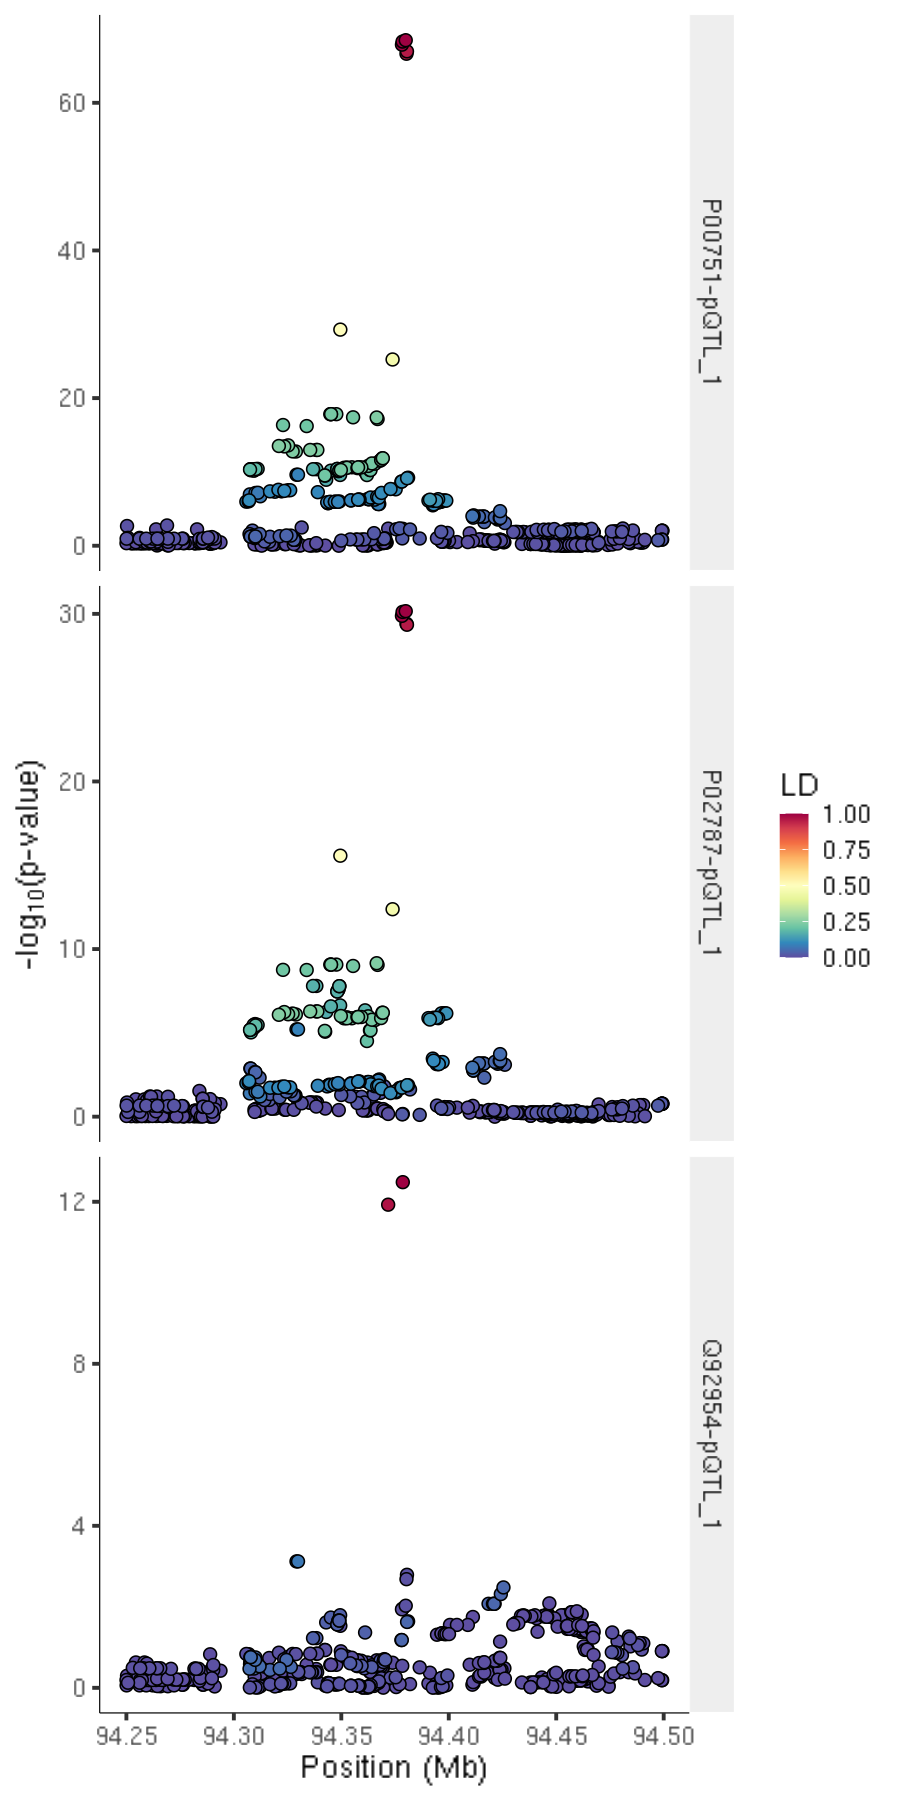

In [43]:
options(repr.plot.width=7.5, repr.plot.height=15)

palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(11, "Spectral")))

merge(protein.locus.data, protein.ld.info, by=c("SNP", "Signal")) %>%
    dplyr::arrange(LD, desc(P_Value)) %>%
    ggplot() +
    geom_point(aes(x=Position / 10^6, y=-log10(P_Value), fill=LD), pch=21, size=I(3)) +
    scale_fill_gradientn(colors=palette(100), limits=c(0, 1)) +
    xlab("Position (Mb)") + ylab(bquote("-log"[10]*"(p-value)")) +
    facet_grid(Signal ~ ., scales="free_y") +
    ggplot_theme +
    theme(legend.position="right")

ggsave("01_Colocalization/results/trans_pqtl_chr_14.pdf", width=7.5, height=15)

## Chr 16 Locus Plot

Retrieve protein summary statistics.

In [44]:
protein.locus.data <- trans.pqtl.summary %>%
    dplyr::filter(pQTL_ID %in% chr.16.ids) %>%
    dplyr::select(SNP, Position, P_Value=pQTL_pval, Signal=pQTL_ID) %>%
    dplyr::filter(Position >= 71.75E6, Position <= 72.5E6)

Generate LD matrix for locus and identify LD as $R^2$ from the lead SNP to all other SNPs.

In [45]:
chr.geno <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/data/genotypes/trans_pqtl_genotypes.raw", sep=" ", drop=2:6)
chr.geno <- as.data.frame(chr.geno)
colnames(chr.geno) <- gsub("X", "", colnames(chr.geno))
colnames(chr.geno) <- sapply(strsplit(colnames(chr.geno), "_"), function(x) { x[1] })
rownames(chr.geno) <- gsub("^GA", "", chr.geno[, 1])
chr.geno[, 1] <- NULL

prot.ld <- cor(chr.geno[,intersect(colnames(chr.geno), protein.locus.data$SNP)], use="pairwise.complete.obs")

In [46]:
protein.ld.info <- do.call(rbind, protein.locus.data %>%
    dplyr::group_by(Signal) %>%
    dplyr::slice_min(P_Value, n=1) %>%
    apply(., 1, function(x) {
        as.data.frame(prot.ld[, x[1]]) %>%
            dplyr::select(LD=1) %>%
            dplyr::mutate(SNP=rownames(.), Signal = x[4], LD=LD^2)
    })
)

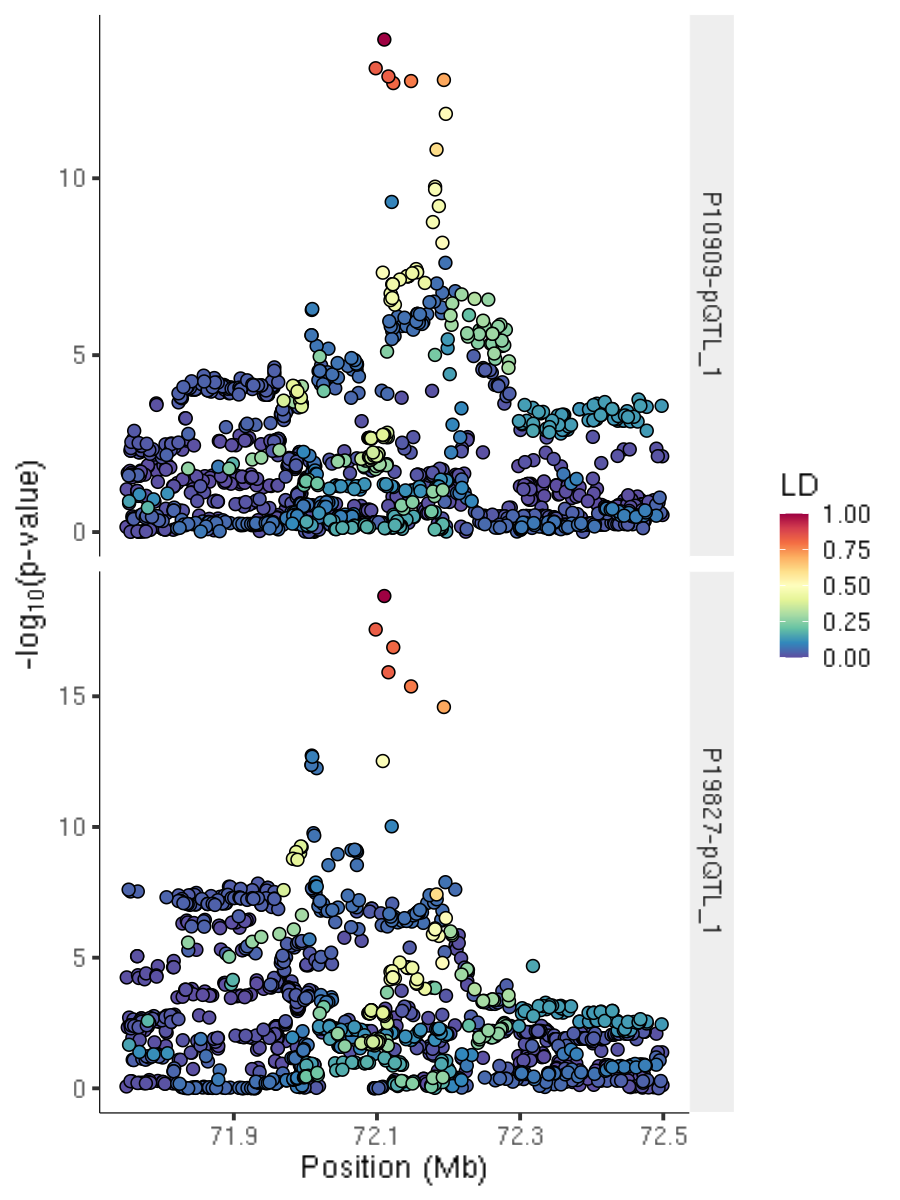

In [49]:
options(repr.plot.width=7.5, repr.plot.height=10)

palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(11, "Spectral")))

merge(protein.locus.data, protein.ld.info, by=c("SNP", "Signal")) %>%
    dplyr::arrange(LD, desc(P_Value)) %>%
    ggplot() +
    geom_point(aes(x=Position / 10^6, y=-log10(P_Value), fill=LD), pch=21, size=I(3)) +
    scale_fill_gradientn(colors=palette(100), limits=c(0, 1)) +
    xlab("Position (Mb)") + ylab(bquote("-log"[10]*"(p-value)")) +
    facet_grid(Signal ~ ., scales="free_y") +
    ggplot_theme +
    theme(legend.position="right")

ggsave("01_Colocalization/results/trans_pqtl_chr_16.pdf", width=7.5, height=10)